# Plotting the Pareto Front from WandB sweeps :

### Imports & Installs :

In [1]:
import wandb
import matplotlib.pyplot as plt
import seaborn as sns

### Get run hashes and load run-table artifacts :  

In [2]:
import pandas as pd

api = wandb.Api()

entity = "algue"
project = "ICLR_Tabular"
states = ["finished", "killed"]  # only runs that did not failed or crashed.
sweeps = {
  '22_magic.gamma': 'alrqcmlh',
  '5_campaign': 'o45yl6gh',
  '8_celeba': 'ld7yp15w',
  '11_donors': 'gzvd2wdc',
  '47_yeast': 'se3o4ifc',
  '9_census': '50v0h64o',
  '32_shuttle': '70i8lk5h',
  '33_skin': '0ohqofvr',
  '1_ALOI': 'os5xmq3w',
  # '23_mammography': '',
}
sweeps_opacus = {
  '22_magic.gamma': '38a9vh6y',
  '5_campaign': 'i95a8iwf',
  '8_celeba': '9s55vik1',
  '11_donors': 'hgl5lv2a',
  '47_yeast': '88vx2ydv',
  '9_census': '094361u3',
  '32_shuttle': 'kgcj1488',
  '33_skin': 'maobrmys',
  '1_ALOI': 'pgpa9cp2',
}
sweep_ids = list(sweeps.values())
filters = {"state": {"$in": states}, 'sweep': {"$in": sweep_ids}}  

# Get a list of all the runs in the project
redownload = False
if redownload:  
  runs = api.runs(entity + "/" + project, filters) 

# summary_list, config_list, name_list = [], [], []
# for run in runs: 
#     # .summary contains the output keys/values for metrics like accuracy.
#     #  We call ._json_dict to omit large files 
#     summary_list.append(run.summary._json_dict)
#     # .config contains the hyperparameters.
#     #  We remove special values that start with _.
#     config_list.append(
#         {k: v for k,v in run.config.items()
#         if not k.startswith('_')})
#     # .name is the human-readable name of the run.
#     name_list.append(run.name)

# runs_df = pd.DataFrame({
#     "summary": summary_list,
#     "config": config_list,
#     "name": name_list
#   })

In [3]:
# expanded_summary = runs_df['summary'].apply(lambda summary: pd.DataFrame.from_dict([summary]))
# df = pd.concat(expanded_summary.tolist(), axis=0)
# df = df.set_index(runs_df['name'])

At this point we only have summary statistics, not the whole statistics. Nonetheless, it is useful if want to select only some runs based on diverse criteria (e.g wandb sweep hyper-parameters).

In [4]:
import numpy as np

def default_delta_value(n):
    smallest_power10_bigger = np.ceil(np.log10(n))
    return int(smallest_power10_bigger)

test_ratio = 0.2
train_ratio = 1 - test_ratio
dataset_size = {
    "5_campaign": int(41188 * train_ratio),
    "8_celeba": int(202599 * train_ratio),
    "22_magic.gamma": int(19020 * train_ratio),
    "47_yeast": int(1484 * train_ratio),
    "11_donors": int(619326 * train_ratio),
    "9_census": int(299285 * train_ratio),
    "32_shuttle": int(49097 * train_ratio),
    "33_skin": int(245057 * train_ratio),
    "1_ALOI": int(49534 * train_ratio),
    # "23_mammography": int(11183 * train_ratio),
}

dataset_features = {
    "5_campaign": 62,
    "8_celeba": 39,
    "22_magic.gamma": 10,
    "47_yeast": 8,
    "11_donors": 10,
    "9_census": 500,
    "32_shuttle": 9,
    "33_skin": 3,
    "1_ALOI": 27,
    # "23_mammography": 6,
}

dataset_delta = {name: default_delta_value(dataset_size[name]) for name in dataset_size}

In [5]:
from joblib import parallel_backend, Parallel, delayed
import tqdm

faulty_runs = {}

def get_hist(run, add_config=True):
    # requires that n_epoch < 1024 to work ! (otherwise increase sample)
    hist = run.history(samples=2048)
    # check for empty runs
    if len(hist) == 0:
      faulty_runs[run.name] = "empty_run"
      return hist
    
    if "epsilon" not in hist.columns:
      faulty_runs[run.name] = "no_epsilon"
      return hist
    
    if "val_auc" not in hist.columns:
      faulty_runs[run.name] = "no_val_auc"
      return hist
    
    # re-order columns and reindex data
    hist = hist.sort_values(by=["epoch", "_step"], axis=0)
    hist = hist.reset_index(drop=True)

    # backward fill the "epsilon" field (reported on epoch+1)
    hist = hist.fillna(method='bfill', limit=1)

    # drop row where epsilon is not known
    hist = hist.dropna(how="any", subset=["epsilon", "val_auc"], axis=0)

    # take one value out of two
    hist = hist.iloc[::2, :]

    hist['name'] = run.name
    if add_config:
      for k, v in run.config.items():
        hist[k] = v
    hist['num_epochs'] = len(hist)

    try:
      hist['runtime'] = run.summary['_runtime']
    except KeyError:
      hist['runtime'] = float('nan')
      faulty_runs[run.name] = "no_runtime"
      return hist
    
    return hist

if redownload:
  # parallel query
  n_jobs = 10
  histories = []
  debug = False
  num_runs = 50 if debug else len(runs)
  with parallel_backend(backend='threading', n_jobs=n_jobs, require='sharedmem'):
    # build pool
    
    pfor = Parallel(n_jobs=n_jobs)(delayed(get_hist)(run, add_config=not debug) for run in tqdm.tqdm(runs[:num_runs]))
    for metrics_dataframe in tqdm.tqdm(pfor):
      # aggregate results in an array
      histories.append(metrics_dataframe)

  # build dataframe with data
  histories = pd.concat(histories)
  histories = histories.sort_values(by=["num_epochs", "name", "epoch", "_step"], axis=0)
  faulty_runs = pd.DataFrame.from_dict(faulty_runs, orient="index", columns=["reason"])

In [6]:
faulty_runs

{}

In [7]:
if redownload:
  histories.to_csv("tabular.csv", index=False)

In [8]:
histories = pd.read_csv("tabular.csv")
histories["Algorithm"] = ["[Lipschitz] Clipless DP-SGD" for _ in histories.index]
histories['dataset_name'].unique()

array(['5_campaign', '47_yeast', '8_celeba', '11_donors', '33_skin',
       '22_magic.gamma', '32_shuttle', '1_ALOI', '9_census'], dtype=object)

In [9]:
def get_hist_opacus(run, add_config=True):
    # requires that n_epoch < 1024 to work ! (otherwise increase sample)
    hist = run.history(samples=2048)
    # check for empty runs
    if len(hist) == 0:
      faulty_runs[run.name] = "empty_run"
      return hist
    
    if "epsilon" not in hist.columns:
      faulty_runs[run.name] = "no_epsilon"
      return hist
    
    if "val_auroc" not in hist.columns:
      faulty_runs[run.name] = "no_val_auc"
      return hist
    
    # re-order columns and reindex data
    hist = hist.sort_values(by=["epoch", "_step"], axis=0)
    hist = hist.reset_index(drop=True)

    # backward fill the "epsilon" field (reported on epoch+1)
    hist = hist.fillna(method='bfill', limit=1)

    # drop row where epsilon is not known
    hist = hist.dropna(how="any", subset=["epsilon", "val_auroc"], axis=0)
    hist["val_auc"] = hist["val_auroc"]
    hist["auc"] = hist["auroc"]
    hist = hist.drop(columns=["val_auroc", "auroc"])

    hist['name'] = run.name
    if add_config:
      for k, v in run.config.items():
        hist[k] = v
    hist['num_epochs'] = len(hist)

    try:
      hist['runtime'] = run.summary['_runtime']
    except KeyError:
      hist['runtime'] = float('nan')
      faulty_runs[run.name] = "no_runtime"
      return hist
    
    return hist

def get_opacus_runs():
  api = wandb.Api()
  entity = "algue"
  project = "ICLR_Opacus_Tabular"
  states = ["finished", "killed", "running"]  # only runs that did not failed or crashed.
  sweep_ids = list(sweeps_opacus.values())
  filters = {"state": {"$in": states}, 'sweep': {"$in": sweep_ids}}  

  runs = api.runs(entity + "/" + project, filters) 

  histories = []
  n_jobs = 10
  debug = False
  with parallel_backend(backend='threading', n_jobs=n_jobs, require='sharedmem'):
    pfor = Parallel(n_jobs=n_jobs)(delayed(get_hist_opacus)(run, add_config=not debug) for run in tqdm.tqdm(runs))
    for metrics_dataframe in tqdm.tqdm(pfor):
      histories.append(metrics_dataframe)

  histories = pd.concat(histories)
  histories = histories.sort_values(by=["num_epochs", "name", "epoch", "_step"], axis=0)
  return histories

opacus_hist = get_opacus_runs()
opacus_hist["Algorithm"] = ["[Unconstrained] DP-SGD" for _ in range(len(opacus_hist))]
opacus_hist

100%|██████████| 74/74 [00:00<00:00, 212733.72it/s]


,_step,loss,_runtime,delta,accuracy,epoch,epsilon,val_epoch,val_accuracy,_timestamp,...,log_wandb,BATCH_SIZE,sweep_count,dataset_name,MAX_GRAD_NORM,sweep_yaml_config,MAX_PHYSICAL_BATCH_SIZE,num_epochs,runtime,Algorithm
0,0,0.141726,13.243446,0.00001,0.067458,1,0.994203,1,0.002921,1.695826e+09,...,sweep_celeba,500,1,8_celeba,15.641288,experiments/paper_plots/opacus_tabular_celeba....,2000,1,13.243446,[Unconstrained] DP-SGD
0,0,0.282124,6.706519,0.00001,0.332581,1,0.990906,1,0.048418,1.695818e+09,...,sweep_celeba,4000,1,8_celeba,0.212050,experiments/paper_plots/opacus_tabular_celeba....,2000,1,6.706519,[Unconstrained] DP-SGD
0,0,134.203330,5.134475,0.00001,0.119470,1,0.992871,1,0.009124,1.695811e+09,...,sweep_ALOI,5000,1,1_ALOI,0.073162,experiments/paper_plots/opacus_tabular_ALOI.yaml,2000,1,5.134475,[Unconstrained] DP-SGD
0,0,44.203109,8.024379,0.00001,0.003230,1,0.805283,1,0.000145,1.695826e+09,...,sweep_celeba,1000,1,8_celeba,91.954707,experiments/paper_plots/opacus_tabular_celeba....,2000,2,12.918013,[Unconstrained] DP-SGD
1,1,12.024511,12.918013,0.00001,0.000199,2,0.991248,2,0.000000,1.695826e+09,...,sweep_celeba,1000,1,8_celeba,91.954707,experiments/paper_plots/opacus_tabular_celeba....,2000,2,12.918013,[Unconstrained] DP-SGD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,181,1.707506,87.931256,0.00001,0.013245,182,0.983863,182,0.015058,1.695824e+09,...,sweep_magic.gamma,2000,1,22_magic.gamma,0.070708,experiments/paper_plots/opacus_tabular_magic.yaml,2000,186,89.897592,[Unconstrained] DP-SGD
182,182,1.725051,88.413407,0.00001,0.013326,183,0.986790,183,0.009371,1.695824e+09,...,sweep_magic.gamma,2000,1,22_magic.gamma,0.070708,experiments/paper_plots/opacus_tabular_magic.yaml,2000,186,89.897592,[Unconstrained] DP-SGD
183,183,1.915484,88.939903,0.00001,0.014903,184,0.989710,184,0.008823,1.695824e+09,...,sweep_magic.gamma,2000,1,22_magic.gamma,0.070708,experiments/paper_plots/opacus_tabular_magic.yaml,2000,186,89.897592,[Unconstrained] DP-SGD
184,184,2.160897,89.360624,0.00001,0.015205,185,0.992623,185,0.006242,1.695824e+09,...,sweep_magic.gamma,2000,1,22_magic.gamma,0.070708,experiments/paper_plots/opacus_tabular_magic.yaml,2000,186,89.897592,[Unconstrained] DP-SGD


<Figure size 3600x2700 with 0 Axes>

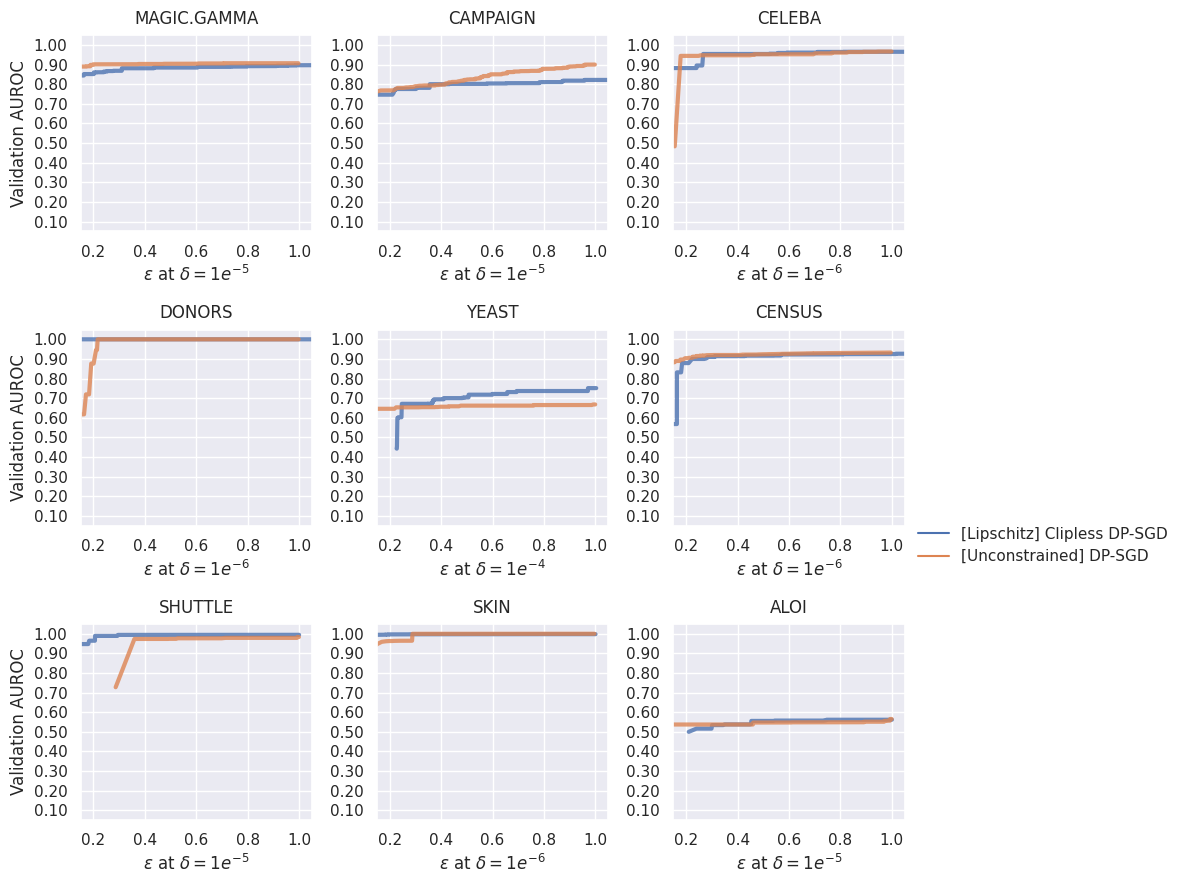

In [10]:
import seaborn as sns
import math

sns.set_context("paper")

def plot_all_datasets(histories, opacus_hist, legend, plot_cloud):
  num_cols = 3
  num_rows = math.ceil(len(sweeps) / num_cols)
  unit_row = 3
  unit_col = 3
  sns.set(rc={'figure.figsize':((num_cols + 1) * unit_col, num_rows * unit_row)})
  sns.set(font_scale=1.0)
  plt.gcf().set_dpi(300)

  axes = plt.subplots(num_rows, num_cols, sharex=False, sharey=False)[1].flatten()

  for i, ax, dataset in zip(range(len(axes)), axes, sweeps):
    delta = dataset_delta[dataset]
    histories_ds = histories[histories['dataset_name'] == dataset]
    pareto_front = histories_ds.set_index("epsilon").sort_values("epsilon")["val_auc"].expanding().max()

    histories_ds_opacus = opacus_hist[opacus_hist['dataset_name'] == dataset]
    pareto_front_opacus = histories_ds_opacus.set_index("epsilon").sort_values("epsilon")["val_auc"].expanding().max()
    
    if plot_cloud:
      sns.scatterplot(data=histories_ds, x="epsilon", y="val_auc",
                      alpha=0.01, c='mediumseagreen', zorder=1, edgecolors=None, ax=ax)

    last_ax = ax == axes[-1]
    df_hist = pd.DataFrame.from_dict({
      'Algorithm': histories_ds['Algorithm'],
      'epsilon': pareto_front.index,
      'val_auc': pareto_front.values,
    })
    df_hist_opacus = pd.DataFrame.from_dict({
      'Algorithm': histories_ds_opacus['Algorithm'],
      'epsilon': pareto_front_opacus.index,
      'val_auc': pareto_front_opacus.values,
    })
    df = pd.concat([df_hist, df_hist_opacus], axis=0)
    sns.lineplot(
      data=df,
      x='epsilon', y='val_auc',
      hue='Algorithm',
      alpha=0.8,
      lw=3,
      errorbar=None,
      legend=(last_ax and legend) and "auto",
      zorder=2,
      ax=ax)

    ax.set(xlim=(0.15, 1.05), ylim=(0.05, 1.05))

    ticks = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    labels = [str(v) for v in ticks]

    subsample = 2
    if subsample:
      ticks = ticks[::subsample]
      labels = labels[::subsample]

    ax.set_xticks(ticks, labels=labels)
    yticks = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    ylabels = list(map(lambda v: f"{v:.2f}", yticks))
    ax.set_yticks(yticks, labels=ylabels)

    ax.set_xlabel(f"$\epsilon$ at $\delta=1e^{{{-delta}}}$")
    if i % num_cols == 0:
      ax.set_ylabel("Validation AUROC")
    else:
      ax.set_ylabel("")
    ax.set_title(f"{''.join(dataset.split('_')[1:]).upper()}", pad=8)

    # move legend to far right
    if last_ax and legend:
      handles, labels = ax.get_legend_handles_labels()
      ax.legend(handles=handles, labels=labels, loc='center left', bbox_to_anchor=(1, 1.4), frameon=False)

  plt.tight_layout()
  plt.subplots_adjust(hspace=0.5)  # Adjust the width space between subplots
  plt.savefig('tabular.png', dpi=300, bbox_inches='tight')

plot_all_datasets(histories, opacus_hist, legend=True, plot_cloud=False)

In [11]:
histories_merged = pd.concat([histories, opacus_hist], axis=0)
small_eps = histories_merged[(histories_merged["epsilon"] <= 1.0) & (histories_merged["epsilon"] >= 0.8)]
small_eps = small_eps[['dataset_name', 'val_auc', 'runtime', 'Algorithm']]
described = small_eps.groupby(["dataset_name", "Algorithm"]).describe()
described = described * 100
described

val_auc                        \
                                                count       mean        std   
dataset_name   Algorithm                                                      
11_donors      [Lipschitz] Clipless DP-SGD   164400.0  96.451578   9.113185   
               [Unconstrained] DP-SGD         11500.0  99.703631   2.322741   
1_ALOI         [Lipschitz] Clipless DP-SGD    23500.0  51.823692   1.798945   
               [Unconstrained] DP-SGD         16000.0  51.188402   1.939941   
22_magic.gamma [Lipschitz] Clipless DP-SGD  1009500.0  82.857822   5.862948   
               [Unconstrained] DP-SGD         20800.0  85.941895   5.492180   
32_shuttle     [Lipschitz] Clipless DP-SGD   173600.0  55.800043  30.400548   
               [Unconstrained] DP-SGD          1500.0  89.333983  22.892754   
33_skin        [Lipschitz] Clipless DP-SGD   774200.0  98.429040   3.957222   
               [Unconstrained] DP-SGD          6700.0  88.947578  22.669838   
47_yeast       [Lipschitz] Clipless DP-SGD   437500.0  57.197655   6.753847   
               [Unconstrained] DP-SGD          8000.0  60.191832   9.062512   
5_campaign     [Lipschitz] Clipless DP-SGD    73400.0  73.598445   7.481093   
               [Unconstrained] DP-SGD         10200.0  83.015317   5.386048   
8_celeba       [Lipschitz] Clipless DP-SGD    30600.0  72.493234  14.873687   
               [Unconstrained] DP-SGD          5300.0  87.757796   9.015357   
9_census       [Lipschitz] Clipless DP-SGD    27600.0  82.784794  13.853022   
               [Unconstrained] DP-SGD         19200.0  88.087718   5.205276   

                                                                             \
                                                  min        25%        50%   
dataset_name   Algorithm                                                      
11_donors      [Lipschitz] Clipless DP-SGD  17.639668  99.460174  99.996766   
               [Unconstrained] DP-SGD       78.022714  99.997559  99.999858   
1_ALOI         [Lipschitz] Clipless DP-SGD  44.709831  50.313932  51.813668   
               [Unconstrained] DP-SGD       47.029400  49.952227  51.207678   
22_magic.gamma [Lipschitz] Clipless DP-SGD  36.686993  81.589234  84.793174   
               [Unconstrained] DP-SGD       45.323727  82.023358  86.323582   
32_shuttle     [Lipschitz] Clipless DP-SGD   0.541935  31.391390  59.078997   
               [Unconstrained] DP-SGD        7.466900  94.076493  94.711019   
33_skin        [Lipschitz] Clipless DP-SGD   7.629676  98.980165  99.390349   
               [Unconstrained] DP-SGD       21.916921  98.232144  98.598746   
47_yeast       [Lipschitz] Clipless DP-SGD  24.503489  52.794755  58.035439   
               [Unconstrained] DP-SGD       42.872297  59.085169  65.025763   
5_campaign     [Lipschitz] Clipless DP-SGD  35.363200  70.984790  76.568681   
               [Unconstrained] DP-SGD       60.435855  77.882855  84.261916   
8_celeba       [Lipschitz] Clipless DP-SGD  29.988620  64.967158  70.648220   
               [Unconstrained] DP-SGD       60.557364  78.140055  92.812696   
9_census       [Lipschitz] Clipless DP-SGD  50.000000  84.121956  90.317890   
               [Unconstrained] DP-SGD       67.565076  85.682278  89.454925   

                                                                     runtime  \
                                                  75%         max      count   
dataset_name   Algorithm                                                       
11_donors      [Lipschitz] Clipless DP-SGD  99.999827  100.000000   164400.0   
               [Unconstrained] DP-SGD       99.999898  100.000000    11500.0   
1_ALOI         [Lipschitz] Clipless DP-SGD  53.124815   55.954248    23500.0   
               [Unconstrained] DP-SGD       52.224942   56.539985    16000.0   
22_magic.gamma [Lipschitz] Clipless DP-SGD  86.414188   89.650577  1009500.0   
               [Unconstrained] DP-SGD       89.948395   90.565502    20800.0   
32_shu

In [12]:
described[("val_auc","iqr")]=described["val_auc"]["75%"]-described["val_auc"]["25%"]
described[("runtime","iqr")]=described["runtime"]["75%"]-described["runtime"]["25%"]
described

val_auc                        \
                                                count       mean        std   
dataset_name   Algorithm                                                      
11_donors      [Lipschitz] Clipless DP-SGD   164400.0  96.451578   9.113185   
               [Unconstrained] DP-SGD         11500.0  99.703631   2.322741   
1_ALOI         [Lipschitz] Clipless DP-SGD    23500.0  51.823692   1.798945   
               [Unconstrained] DP-SGD         16000.0  51.188402   1.939941   
22_magic.gamma [Lipschitz] Clipless DP-SGD  1009500.0  82.857822   5.862948   
               [Unconstrained] DP-SGD         20800.0  85.941895   5.492180   
32_shuttle     [Lipschitz] Clipless DP-SGD   173600.0  55.800043  30.400548   
               [Unconstrained] DP-SGD          1500.0  89.333983  22.892754   
33_skin        [Lipschitz] Clipless DP-SGD   774200.0  98.429040   3.957222   
               [Unconstrained] DP-SGD          6700.0  88.947578  22.669838   
47_yeast       [Lipschitz] Clipless DP-SGD   437500.0  57.197655   6.753847   
               [Unconstrained] DP-SGD          8000.0  60.191832   9.062512   
5_campaign     [Lipschitz] Clipless DP-SGD    73400.0  73.598445   7.481093   
               [Unconstrained] DP-SGD         10200.0  83.015317   5.386048   
8_celeba       [Lipschitz] Clipless DP-SGD    30600.0  72.493234  14.873687   
               [Unconstrained] DP-SGD          5300.0  87.757796   9.015357   
9_census       [Lipschitz] Clipless DP-SGD    27600.0  82.784794  13.853022   
               [Unconstrained] DP-SGD         19200.0  88.087718   5.205276   

                                                                             \
                                                  min        25%        50%   
dataset_name   Algorithm                                                      
11_donors      [Lipschitz] Clipless DP-SGD  17.639668  99.460174  99.996766   
               [Unconstrained] DP-SGD       78.022714  99.997559  99.999858   
1_ALOI         [Lipschitz] Clipless DP-SGD  44.709831  50.313932  51.813668   
               [Unconstrained] DP-SGD       47.029400  49.952227  51.207678   
22_magic.gamma [Lipschitz] Clipless DP-SGD  36.686993  81.589234  84.793174   
               [Unconstrained] DP-SGD       45.323727  82.023358  86.323582   
32_shuttle     [Lipschitz] Clipless DP-SGD   0.541935  31.391390  59.078997   
               [Unconstrained] DP-SGD        7.466900  94.076493  94.711019   
33_skin        [Lipschitz] Clipless DP-SGD   7.629676  98.980165  99.390349   
               [Unconstrained] DP-SGD       21.916921  98.232144  98.598746   
47_yeast       [Lipschitz] Clipless DP-SGD  24.503489  52.794755  58.035439   
               [Unconstrained] DP-SGD       42.872297  59.085169  65.025763   
5_campaign     [Lipschitz] Clipless DP-SGD  35.363200  70.984790  76.568681   
               [Unconstrained] DP-SGD       60.435855  77.882855  84.261916   
8_celeba       [Lipschitz] Clipless DP-SGD  29.988620  64.967158  70.648220   
               [Unconstrained] DP-SGD       60.557364  78.140055  92.812696   
9_census       [Lipschitz] Clipless DP-SGD  50.000000  84.121956  90.317890   
               [Unconstrained] DP-SGD       67.565076  85.682278  89.454925   

                                                                     runtime  \
                                                  75%         max      count   
dataset_name   Algorithm                                                       
11_donors      [Lipschitz] Clipless DP-SGD  99.999827  100.000000   164400.0   
               [Unconstrained] DP-SGD       99.999898  100.000000    11500.0   
1_ALOI         [Lipschitz] Clipless DP-SGD  53.124815   55.954248    23500.0   
               [Unconstrained] DP-SGD       52.224942   56.539985    16000.0   
22_magic.gamma [Lipschitz] Clipless DP-SGD  86.414188   89.650577  1009500.0   
               [Unconstrained] DP-SGD       89.948395   90.565502    20800.0   
32_shu

In [59]:
def report_stats(with_runtime):
  for ds in sorted(dataset_delta, key=lambda k: int(k.split('_')[0])):
    delta = dataset_delta[ds]
    ds_features = dataset_features[ds]
    ds_size = dataset_size[ds]
    ds_name = ''.join(ds.split('_')[1:]) if ds != "22_magic.gamma" else "magic"

    target = "75%"

    row = described.loc[(ds, "[Lipschitz] Clipless DP-SGD"), :]
    median = float(row["val_auc"][target])
    iqr = float(row["val_auc"]["iqr"])
    result_str = f'{median:.1f}~({iqr:.1f})'
    runtime = float(row["runtime"][target])
    runtime_std = float(row["runtime"]["iqr"])

    row_opacus = described.loc[(ds, "[Unconstrained] DP-SGD"), :]
    median_opacus = float(row_opacus["val_auc"][target])
    iqr_opacus = float(row_opacus["val_auc"]["iqr"])
    result_str_opacus = f'{median_opacus:.1f}~({iqr_opacus:.1f})'
    runtime_opacus = float(row_opacus["runtime"][target])
    runtime_std_opacus = float(row_opacus["runtime"]["iqr"])

    if median > median_opacus:
      result_str = f"\\textbf{{{result_str}}}"
    else:
      result_str_opacus = f"\\textbf{{{result_str_opacus}}}"

    if runtime < runtime_opacus:
      runtime = f"\\textbf{{{runtime:.1f}}}"
      runtime_opacus = f"{runtime_opacus:.1f}"
    else:
      runtime = f"{runtime:.1f}"
      runtime_opacus = f"\\textbf{{{runtime_opacus:.1f}}}"

    tokens = [f"{ds_name}", f"{ds_size:,}", f"{ds_features:,}", f"$10^{{{-delta}}}$",
              f"{result_str_opacus}", f"{result_str}"]
    
    if with_runtime:
      tokens += [f"{runtime_opacus}~({runtime_std_opacus:.1f})",
                 f"{runtime}~({runtime_std:.1f})"]

    print(f"{' & '.join(tokens)} \\\\")
report_stats(with_runtime=False)

ALOI & 39,627 & 27 & $10^{-5}$ & 52.2~(2.3) & \textbf{53.1~(2.8)} \\
campaign & 32,950 & 62 & $10^{-5}$ & \textbf{87.8~(9.9)} & 78.7~(7.7) \\
celeba & 162,079 & 39 & $10^{-6}$ & \textbf{94.0~(15.9)} & 81.5~(16.5) \\
census & 239,428 & 500 & $10^{-6}$ & \textbf{91.7~(6.1)} & 91.4~(7.3) \\
donors & 495,460 & 10 & $10^{-6}$ & \textbf{100.0~(0.0)} & 100.0~(0.5) \\
magic & 15,216 & 10 & $10^{-5}$ & \textbf{89.9~(7.9)} & 86.4~(4.8) \\
shuttle & 39,277 & 9 & $10^{-5}$ & \textbf{97.7~(3.6)} & 82.4~(51.0) \\
skin & 196,045 & 3 & $10^{-6}$ & 98.9~(0.7) & \textbf{99.6~(0.6)} \\
yeast & 1,187 & 8 & $10^{-4}$ & \textbf{65.7~(6.7)} & 62.1~(9.3) \\


In [60]:
def report_best(with_runtime):
  small_eps = histories_merged[(histories_merged["epsilon"] <= 1.0)]
  small_eps = small_eps[['dataset_name', 'val_auc', 'runtime', 'Algorithm']]
  for ds in sorted(dataset_delta, key=lambda k: int(k.split('_')[0])):
    ds_name = ''.join(ds.split('_')[1:]) if ds != "22_magic.gamma" else "magic"

    small_eps_ds = small_eps[(small_eps["dataset_name"] == ds) & (small_eps["Algorithm"] == "[Lipschitz] Clipless DP-SGD")]
    idx = small_eps_ds['val_auc'].argmax()
    row = small_eps_ds.iloc[idx]

    delta = dataset_delta[ds]
    ds_features = dataset_features[ds]
    ds_size = dataset_size[ds]

    max_auroc = float(row["val_auc"])*100
    runtime = float(row["runtime"])
    result_str = f'{max_auroc:.1f}'

    small_eps_ds_opacus = small_eps[(small_eps["dataset_name"] == ds) & (small_eps["Algorithm"] == "[Unconstrained] DP-SGD")]
    idx = small_eps_ds_opacus['val_auc'].argmax()
    row_opacus = small_eps_ds_opacus.iloc[idx]
    max_auroc_opacus = float(row_opacus["val_auc"])*100
    runtime_opacus = float(row_opacus["runtime"])
    result_str_opacus = f'{max_auroc_opacus:.1f}'

    if max_auroc > max_auroc_opacus:
      result_str = f"\\textbf{{{result_str}}}"
    else:
      result_str_opacus = f"\\textbf{{{result_str_opacus}}}"

    if runtime < runtime_opacus:
      runtime = f"\\textbf{{{runtime:.1f}}}"
      runtime_opacus = f"{runtime_opacus:.1f}"
    else:
      runtime = f"{runtime:.1f}"
      runtime_opacus = f"\\textbf{{{runtime_opacus:.1f}}}"

    tokens = [f"{ds_name}", f"{ds_size:,}", f"{ds_features:,}", f"$10^{{{-delta}}}$",
              f"${result_str_opacus}$", f"${result_str}$"]
    
    if with_runtime:
      tokens += [f"${runtime_opacus}$", f"${runtime}$"]

    full_str = ' & '.join(tokens)
    print(f"{full_str}\\\\")
report_best(with_runtime=False)

ALOI & 39,627 & 27 & $10^{-5}$ & $\textbf{56.5}$ & $56.2$\\
campaign & 32,950 & 62 & $10^{-5}$ & $\textbf{90.0}$ & $82.2$\\
celeba & 162,079 & 39 & $10^{-6}$ & $\textbf{96.6}$ & $96.5$\\
census & 239,428 & 500 & $10^{-6}$ & $\textbf{93.3}$ & $92.5$\\
donors & 495,460 & 10 & $10^{-6}$ & $100.0$ & $\textbf{100.0}$\\
magic & 15,216 & 10 & $10^{-5}$ & $\textbf{90.7}$ & $89.7$\\
shuttle & 39,277 & 9 & $10^{-5}$ & $98.3$ & $\textbf{99.4}$\\
skin & 196,045 & 3 & $10^{-6}$ & $\textbf{100.0}$ & $99.8$\\
yeast & 1,187 & 8 & $10^{-4}$ & $66.8$ & $\textbf{75.1}$\\
